# **XSSGAI** is the first-ever AI-powered XSS (Cross-Site Scripting) payload generator. It leverages machine learning and deep learning to create novel payloads based on patterns from real-world XSS attacks.

# Created by: **AnonKryptiQuz**

**Performing EDA**

In [21]:
!pip install tensorflow

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sentencepiece as spm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud
from collections import Counter
from sre_constants import MAX_REPEAT

In [2]:
with open('train_payloads.txt', 'r', encoding='utf-8') as file:
    train_payloads = file.readlines()

with open('test_payloads.txt', 'r', encoding='utf-8') as file:
    test_payloads = file.readlines()

train_payloads_df = pd.DataFrame(train_payloads, columns=['payload'])
test_payloads_df = pd.DataFrame(test_payloads, columns=['payload'])

In [3]:
print("Training Payloads (First 5 rows):")
print(train_payloads_df.head())

print("\nTesting Payloads (First 5 rows):")
print(test_payloads_df.head())

Training Payloads (First 5 rows):
                                             payload
0  {{constructor.constructor(valueOf.name.constru...
1  <blockquote id=x tabindex=1 ondeactivate=alert...
2  <!--><svg+onload=%27top[%2fal%2f%2esource%2b%2...
3  <data onblur=alert(1) id=x tabindex=1 style=di...
4  <details onmouseup="alert(1)">AnonKryptiQuz</d...

Testing Payloads (First 5 rows):
                                             payload
0  <script id=x tabindex=1 onbeforeactivate=alert...
1  <style>:target {color:red;}</style><legend id=...
2  <summary onpointerout=alert(1) style=display:b...
3  &lt;BODY BACKGROUND=&quot;javascript:alert(&ap...
4  <animate onpointerdown=alert(1) style=display:...


In [4]:
print("Training Payloads (Last 5 rows):")
print(train_payloads_df.tail())

print("\nTesting Payloads (Last 5 rows):")
print(test_payloads_df.tail())

Training Payloads (Last 5 rows):
                                                 payload
14432  <style>:target {color:red;}</style><mark id=x ...
14433  <style>:target {color: red;}</style><xmp id=x ...
14434  <details onpaste="alert(1)" contenteditable>An...
14435  <data onmouseover="alert(1)" style=display:blo...
14436  <tbody onbeforecopy="alert(1)" contenteditable...

Testing Payloads (Last 5 rows):
                                                payload
3604                                       a=\"get\";\n
3605  <p oncopy=alert(1) value="AnonKryptiQuz" autof...
3606  <div draggable="true" contenteditable>drag me<...
3607  "`'><script>\xE2\x80\x8Ajavascript:alert(1)</s...
3608                     <div id="97"><!-- IE 5-9 -->\n


In [5]:
print("Training Dataset Dimensions:")
print(train_payloads_df.shape)

print("\nTesting Dataset Dimensions:")
print(test_payloads_df.shape)

Training Dataset Dimensions:
(14437, 1)

Testing Dataset Dimensions:
(3609, 1)


In [6]:
print("Training Dataset Info:")
print(train_payloads_df.info())

print("\nTesting Dataset Info:")
print(test_payloads_df.info())

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   payload  14437 non-null  object
dtypes: object(1)
memory usage: 112.9+ KB
None

Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   payload  3609 non-null   object
dtypes: object(1)
memory usage: 28.3+ KB
None


In [7]:
print("Training Dataset Data Types:")
print(train_payloads_df.dtypes)

print("\nTesting Dataset Data Types:")
print(test_payloads_df.dtypes)

Training Dataset Data Types:
payload    object
dtype: object

Testing Dataset Data Types:
payload    object
dtype: object


In [8]:
print("Missing Values in Training Dataset:")
print(train_payloads_df.isnull().sum())

print("\nMissing Values in Testing Dataset:")
print(test_payloads_df.isnull().sum())

Missing Values in Training Dataset:
payload    0
dtype: int64

Missing Values in Testing Dataset:
payload    0
dtype: int64


In [9]:
print("Duplicate Values in Training Dataset:")
print(train_payloads_df.duplicated().sum())

print("\nDuplicate Values in Testing Dataset:")
print(test_payloads_df.duplicated().sum())

Duplicate Values in Training Dataset:
0

Duplicate Values in Testing Dataset:
0


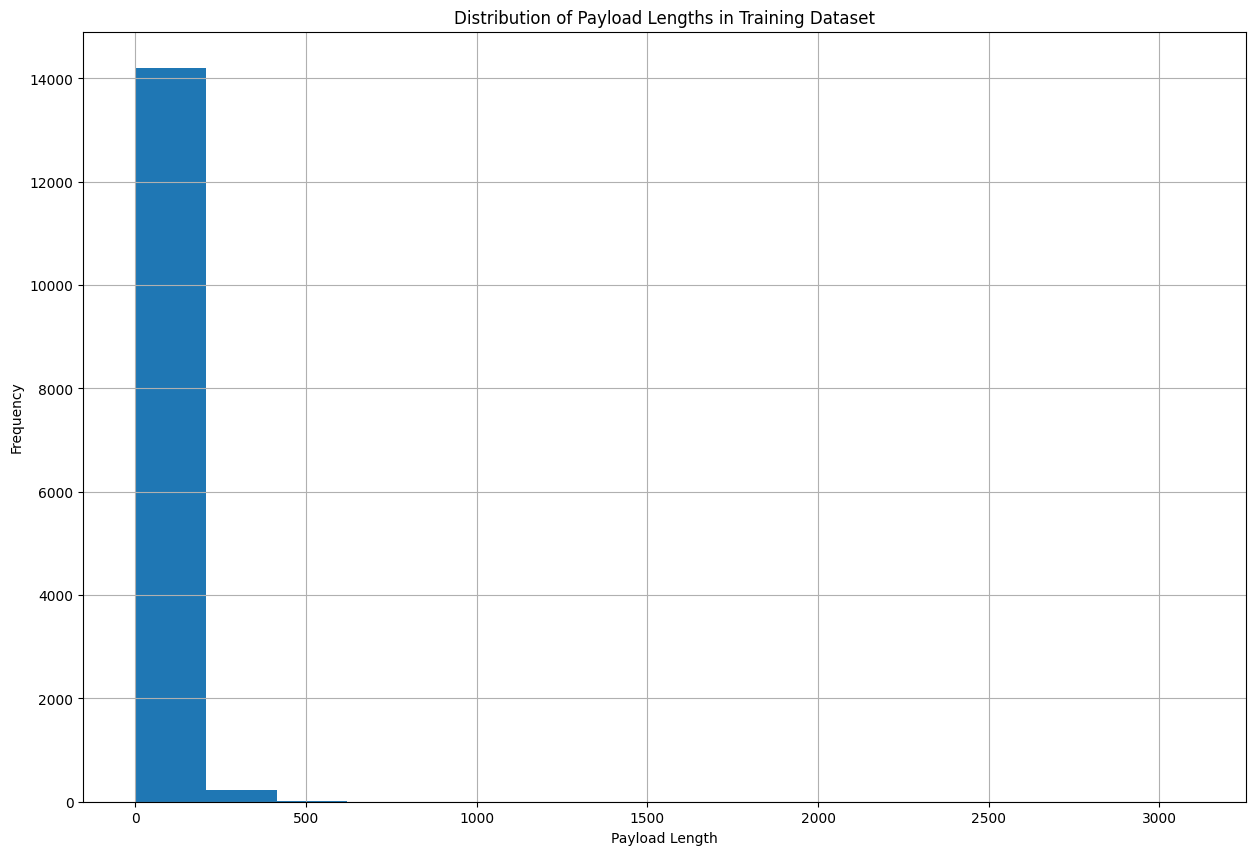

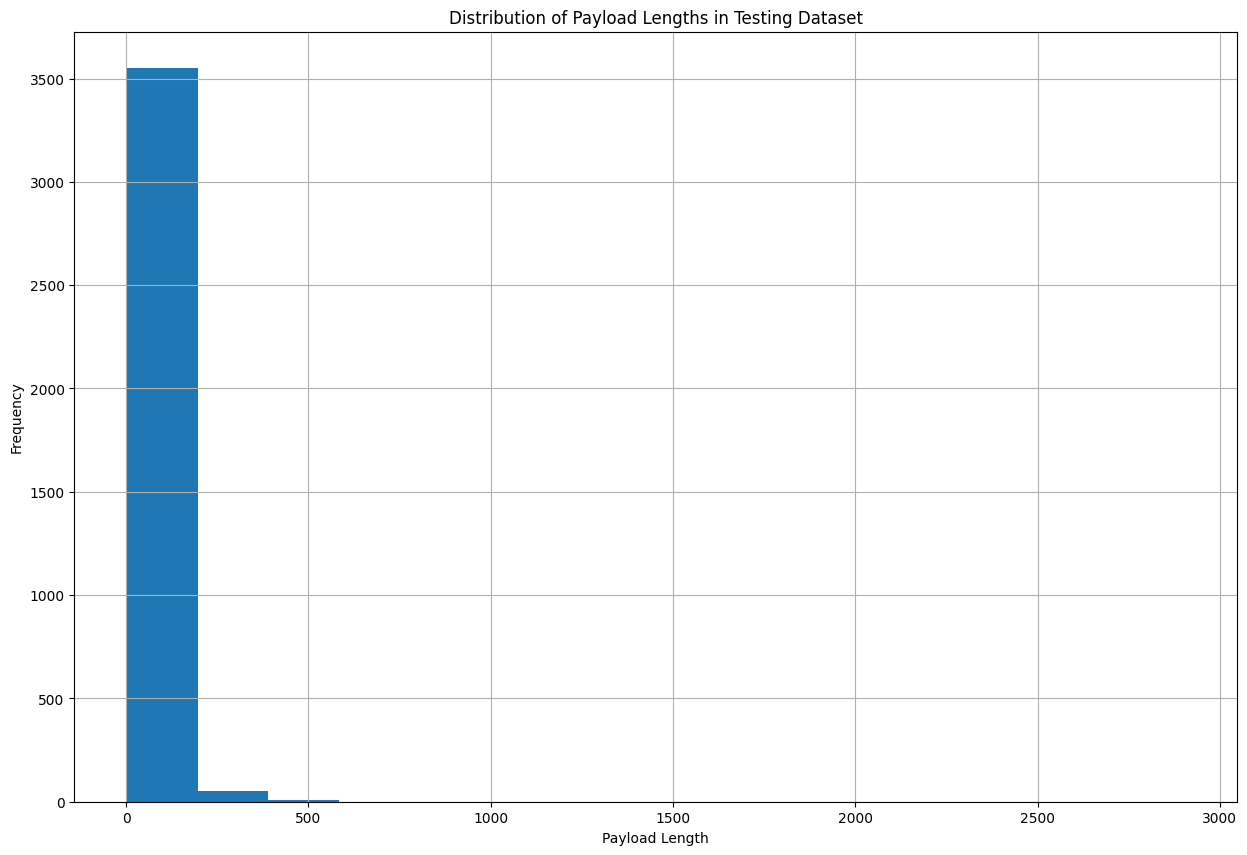

In [10]:
train_payloads_df['length'] = train_payloads_df['payload'].apply(len)
test_payloads_df['length'] = test_payloads_df['payload'].apply(len)

plt.figure(figsize=(15, 10))
train_payloads_df['length'].hist(bins=15)
plt.title("Distribution of Payload Lengths in Training Dataset")
plt.xlabel('Payload Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(15, 10))
test_payloads_df['length'].hist(bins=15)
plt.title("Distribution of Payload Lengths in Testing Dataset")
plt.xlabel('Payload Length')
plt.ylabel('Frequency')
plt.show()

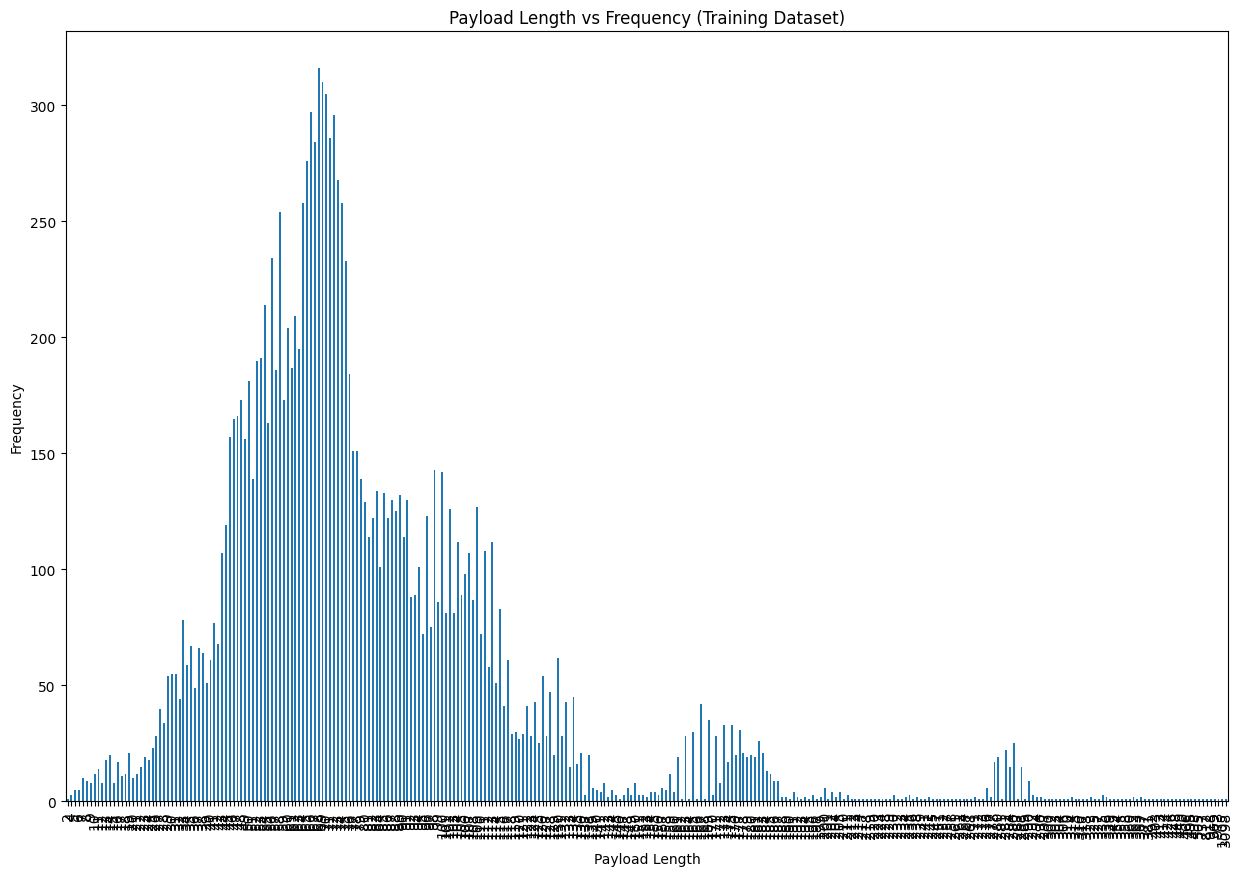

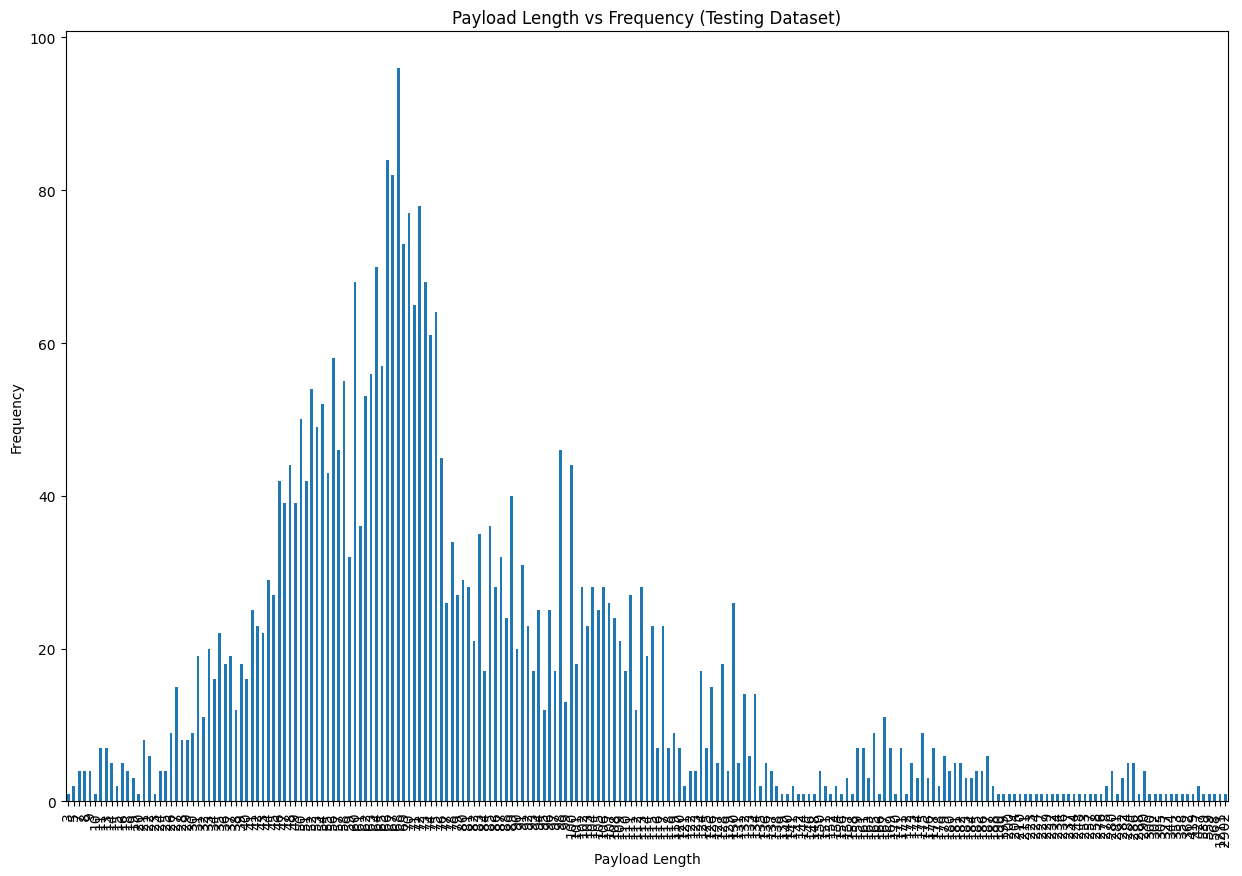

In [11]:
plt.figure(figsize=(15, 10))
train_payloads_df['length'].value_counts().sort_index().plot(kind='bar')
plt.title('Payload Length vs Frequency (Training Dataset)')
plt.xlabel('Payload Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(15, 10))
test_payloads_df['length'].value_counts().sort_index().plot(kind='bar')
plt.title('Payload Length vs Frequency (Testing Dataset)')
plt.xlabel('Payload Length')
plt.ylabel('Frequency')
plt.show()

Maximum payload length in Training Dataset: 3098
Maximum payload length in Testing Dataset: 2902


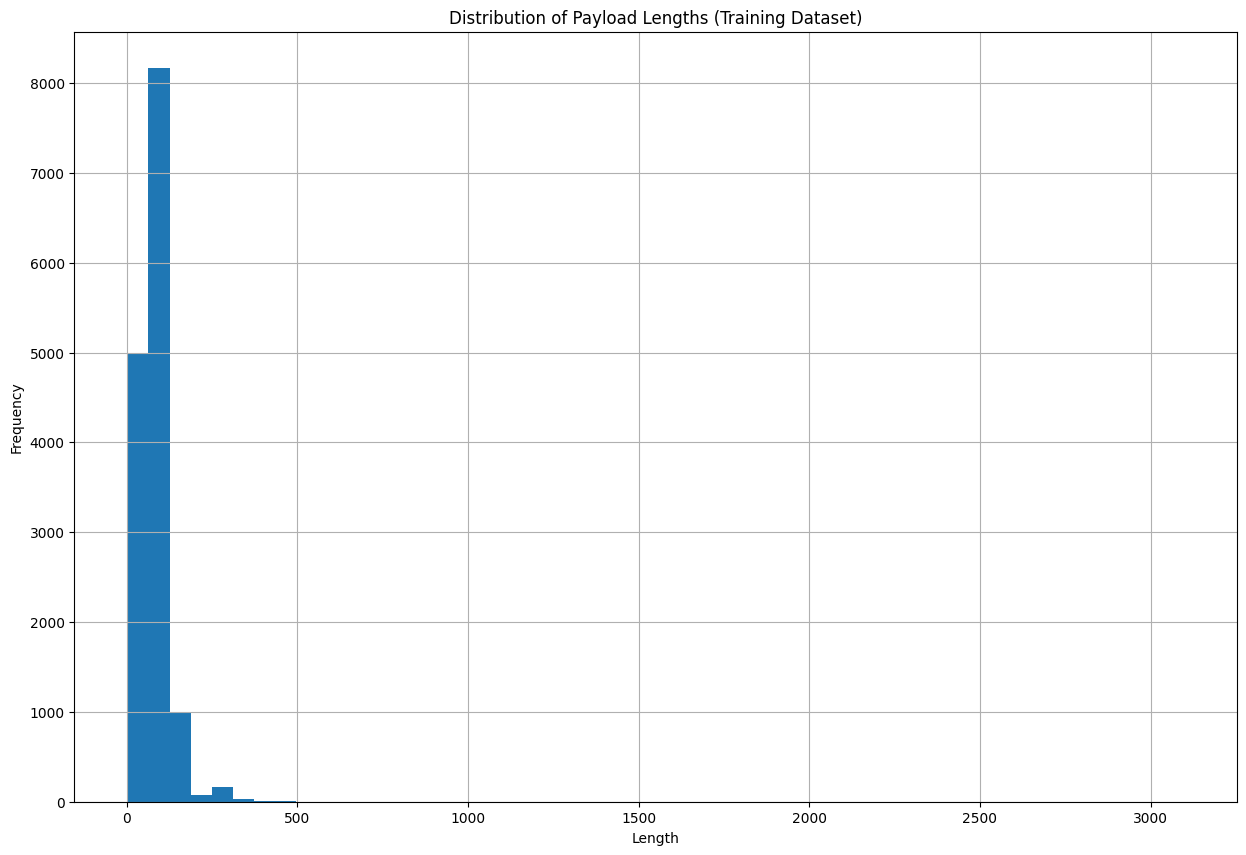

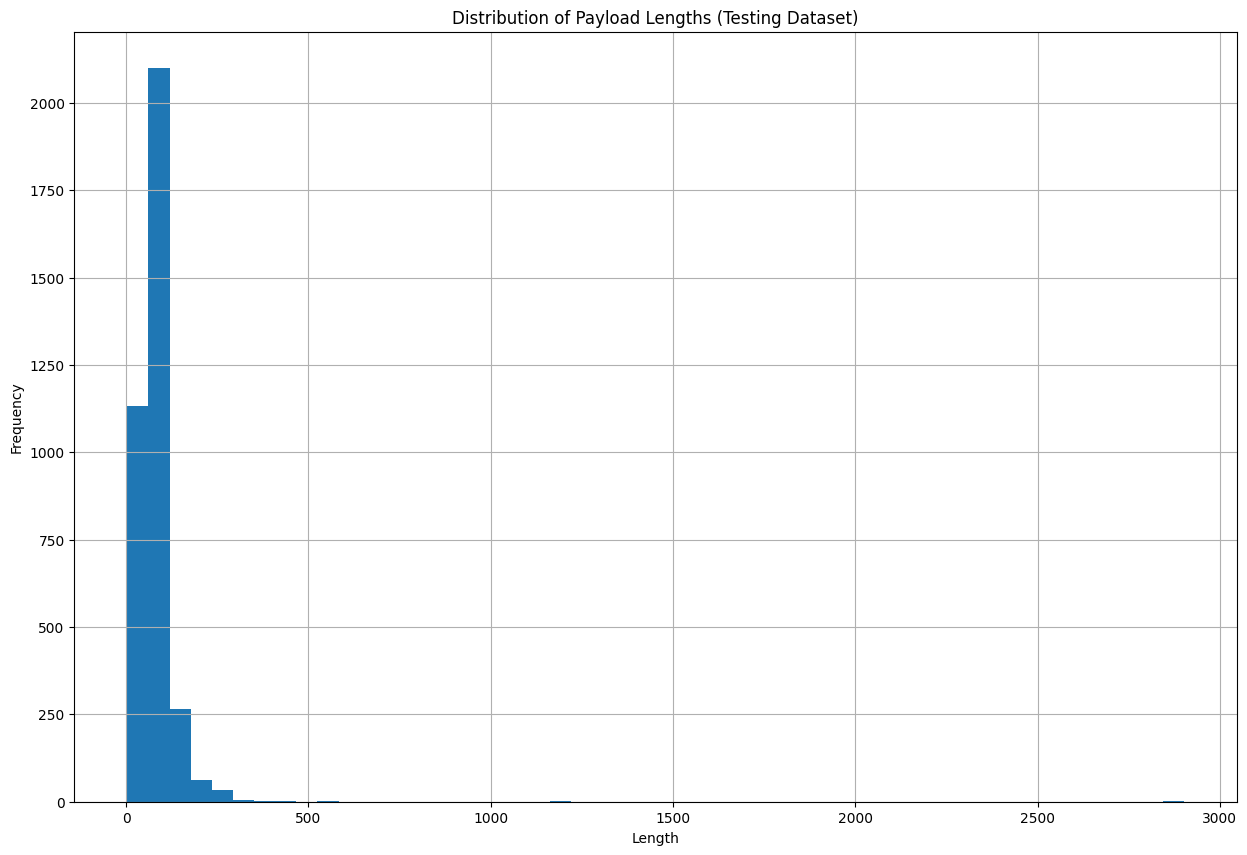

In [12]:
max_train_payload_length = train_payloads_df['length'].max()
max_test_payload_length = test_payloads_df['length'].max()

print("Maximum payload length in Training Dataset:", max_train_payload_length)
print("Maximum payload length in Testing Dataset:", max_test_payload_length)

plt.figure(figsize=(15, 10))
train_payloads_df['length'].hist(bins=50)
plt.title("Distribution of Payload Lengths (Training Dataset)")
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(15, 10))
test_payloads_df['length'].hist(bins=50)
plt.title("Distribution of Payload Lengths (Testing Dataset)")
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
print("Training Dataset Payload Lengths Descriptive Statistics:")
print(train_payloads_df['length'].describe())

print("\nTesting Dataset Payload Lengths Descriptive Statistics:")
print(test_payloads_df['length'].describe())

Training Dataset Payload Lengths Descriptive Statistics:
count    14437.000000
mean        81.112212
std         52.711103
min          2.000000
25%         57.000000
50%         71.000000
75%         95.000000
max       3098.000000
Name: length, dtype: float64

Testing Dataset Payload Lengths Descriptive Statistics:
count    3609.000000
mean       81.038792
std        66.433136
min         3.000000
25%        56.000000
50%        70.000000
75%        96.000000
max      2902.000000
Name: length, dtype: float64


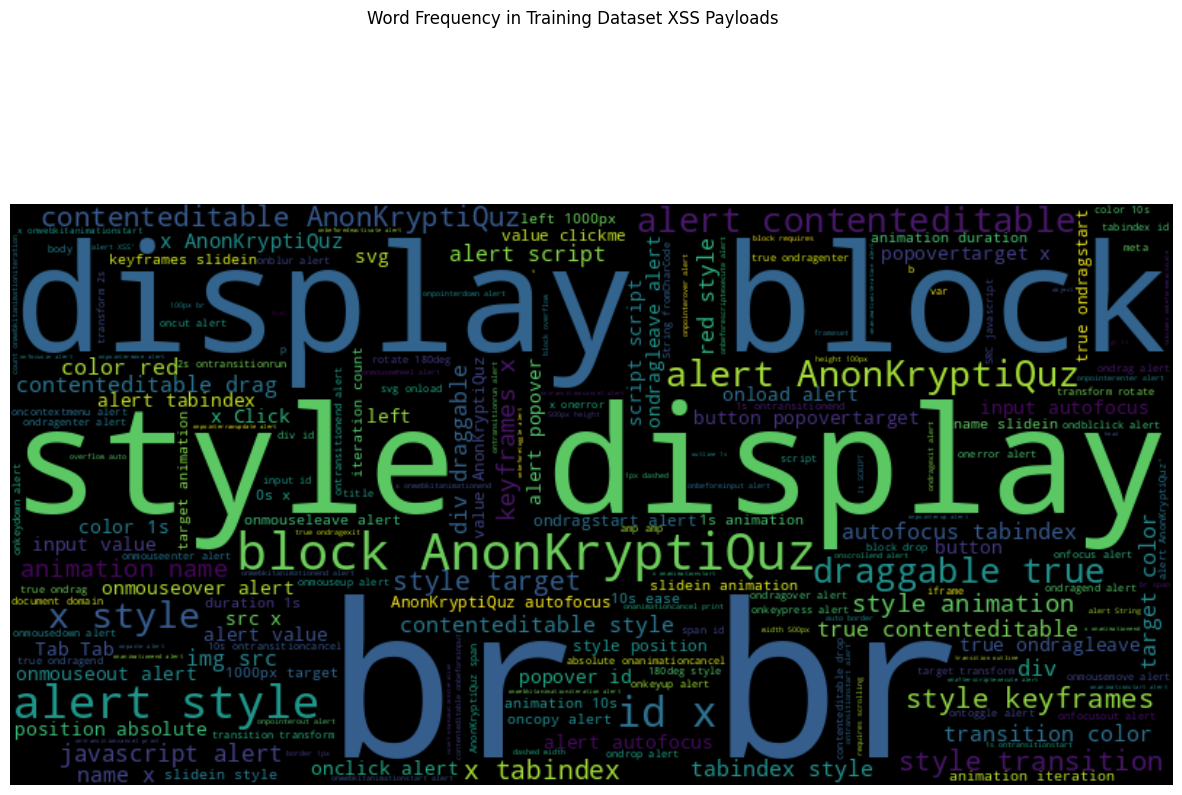

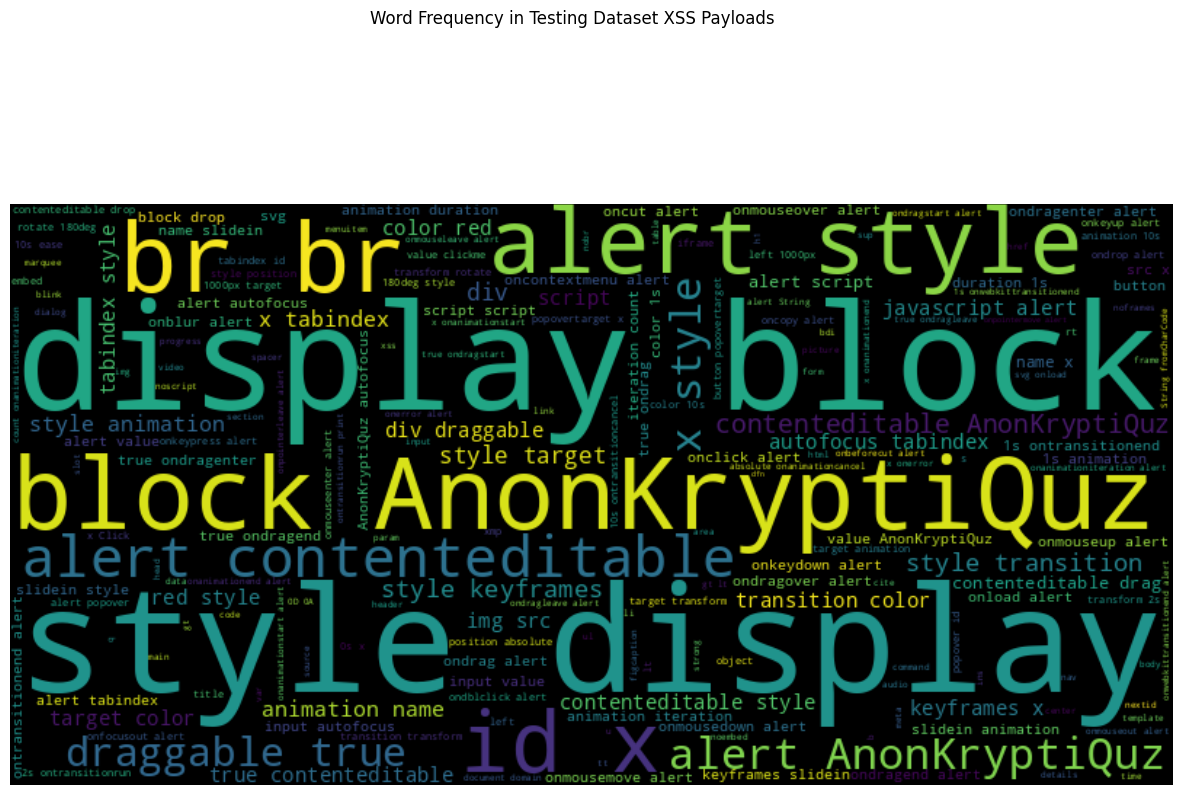

In [14]:
all_train_payloads = " ".join(train_payloads_df['payload'])
train_wordcloud = WordCloud(width=800, height=400).generate(all_train_payloads)

plt.figure(figsize=(15, 10))
plt.imshow(train_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle("Word Frequency in Training Dataset XSS Payloads")
plt.show()

all_test_payloads = " ".join(test_payloads_df['payload'])
test_wordcloud = WordCloud(width=800, height=400).generate(all_test_payloads)

plt.figure(figsize=(15, 10))
plt.imshow(test_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle("Word Frequency in Testing Dataset XSS Payloads")
plt.show()

In [15]:
train_payloads_df['length'] = train_payloads_df['payload'].apply(len)
test_payloads_df['length'] = test_payloads_df['payload'].apply(len)

print("Training Dataset Columns:", train_payloads_df.columns)
print("Testing Dataset Columns:", test_payloads_df.columns)

Training Dataset Columns: Index(['payload', 'length'], dtype='object')
Testing Dataset Columns: Index(['payload', 'length'], dtype='object')


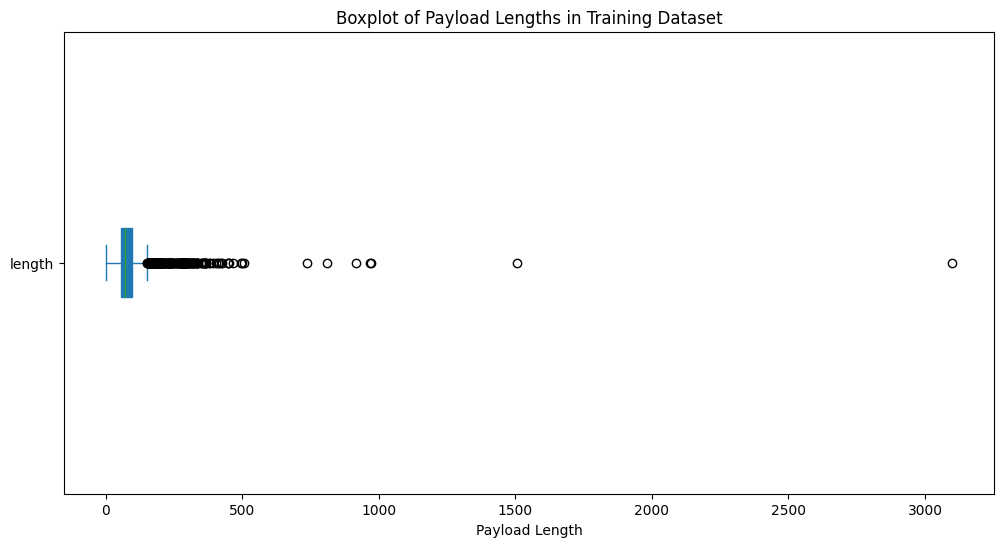

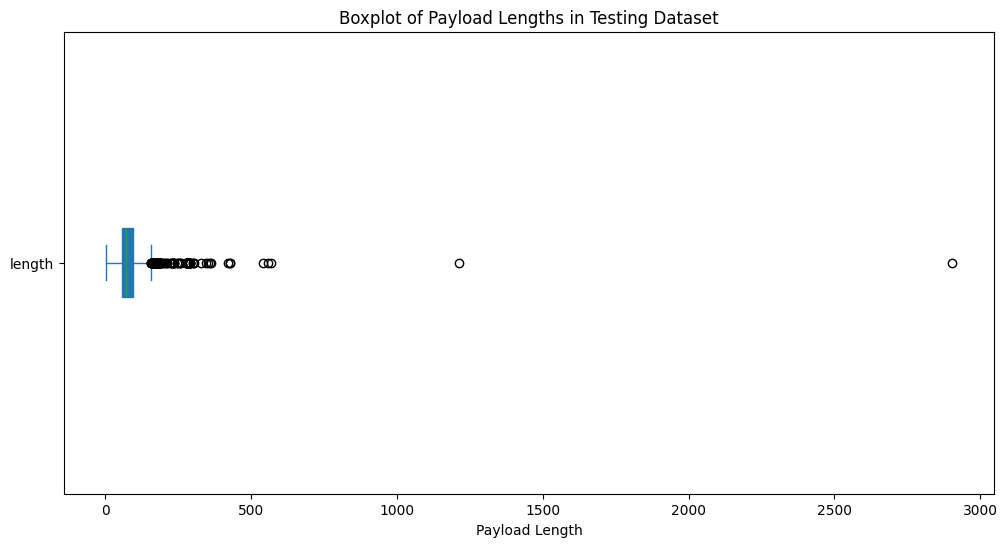

In [16]:
plt.figure(figsize=(12, 6))
train_payloads_df['length'].plot(kind='box', vert=False, patch_artist=True)
plt.title('Boxplot of Payload Lengths in Training Dataset')
plt.xlabel('Payload Length')
plt.show()

plt.figure(figsize=(12, 6))
test_payloads_df['length'].plot(kind='box', vert=False, patch_artist=True)
plt.title('Boxplot of Payload Lengths in Testing Dataset')
plt.xlabel('Payload Length')
plt.show()

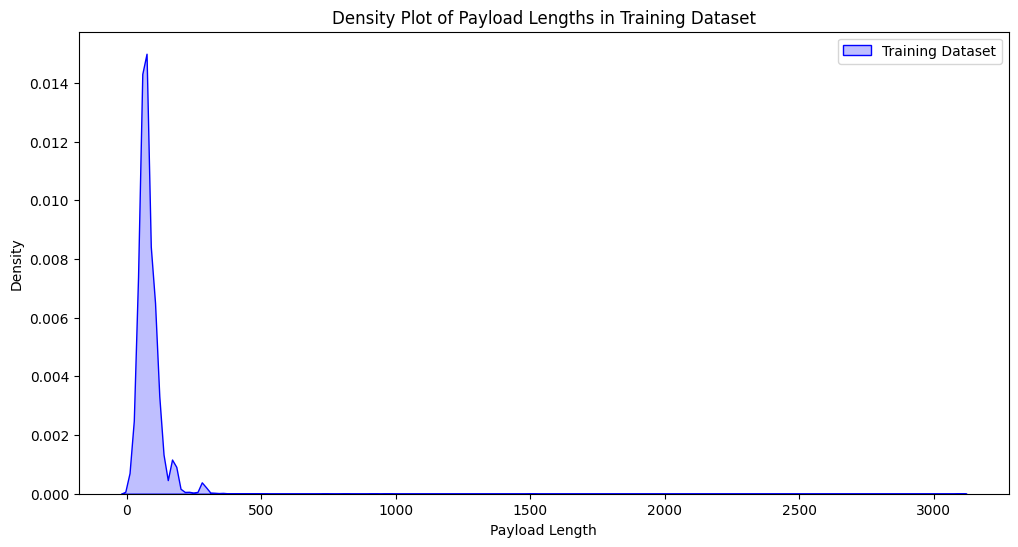

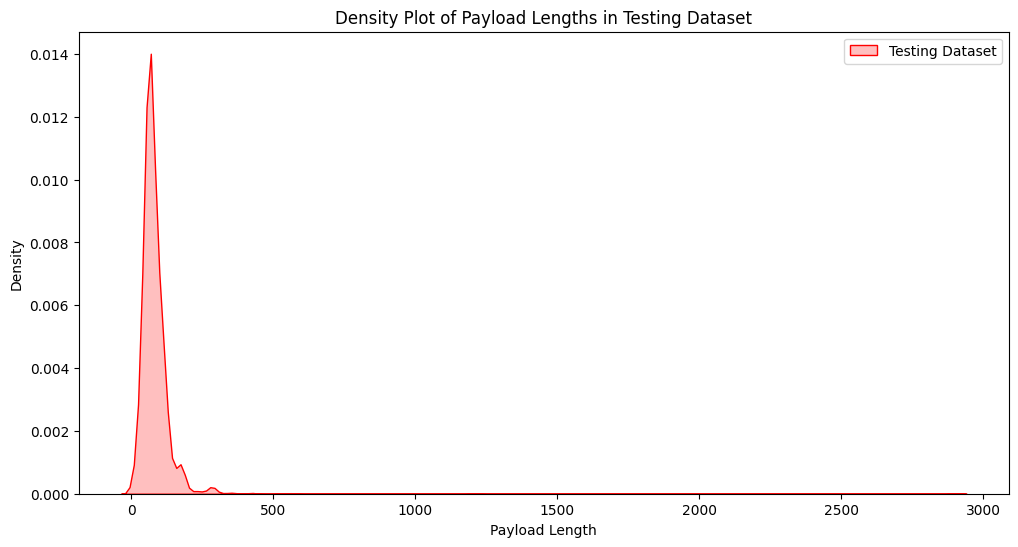

In [17]:
plt.figure(figsize=(12, 6))
sns.kdeplot(train_payloads_df['length'], fill=True, color='blue', label='Training Dataset')
plt.title('Density Plot of Payload Lengths in Training Dataset')
plt.xlabel('Payload Length')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(test_payloads_df['length'], fill=True, color='red', label='Testing Dataset')
plt.title('Density Plot of Payload Lengths in Testing Dataset')
plt.xlabel('Payload Length')
plt.ylabel('Density')
plt.legend()
plt.show()

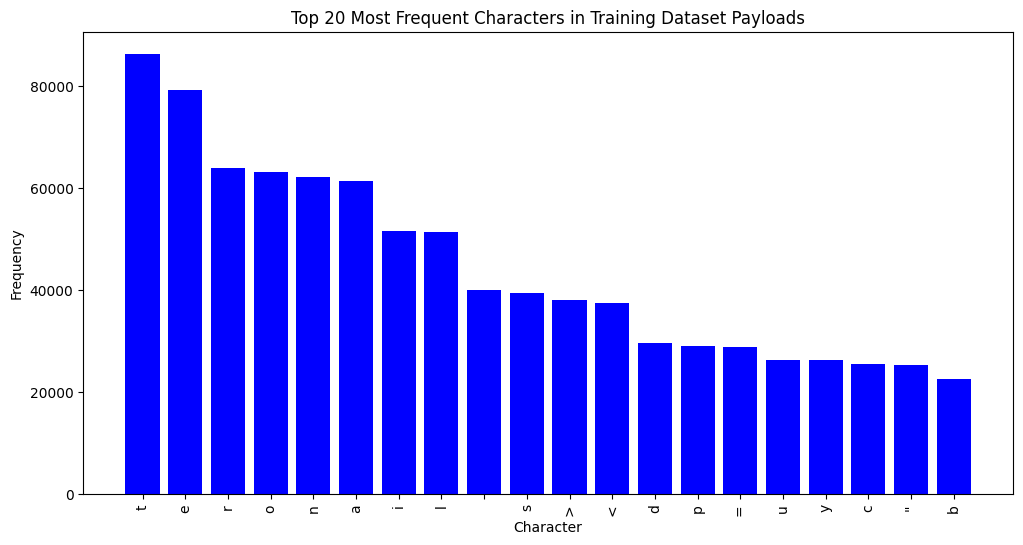

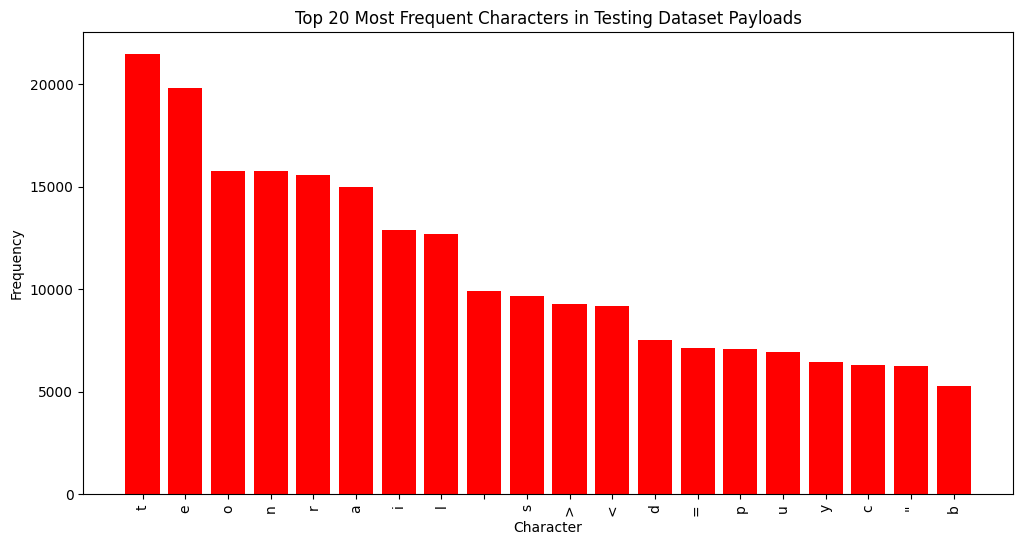

In [18]:
all_train_payloads = ''.join(train_payloads_df['payload'])
all_test_payloads = ''.join(test_payloads_df['payload'])

train_char_freq = Counter(all_train_payloads)
test_char_freq = Counter(all_test_payloads)

train_char_freq_df = pd.DataFrame(train_char_freq.items(), columns=['Character', 'Frequency'])
train_char_freq_df = train_char_freq_df.sort_values(by='Frequency', ascending=False).head(20)

test_char_freq_df = pd.DataFrame(test_char_freq.items(), columns=['Character', 'Frequency'])
test_char_freq_df = test_char_freq_df.sort_values(by='Frequency', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.bar(train_char_freq_df['Character'], train_char_freq_df['Frequency'], color='blue')
plt.title('Top 20 Most Frequent Characters in Training Dataset Payloads')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(test_char_freq_df['Character'], test_char_freq_df['Frequency'], color='red')
plt.title('Top 20 Most Frequent Characters in Testing Dataset Payloads')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

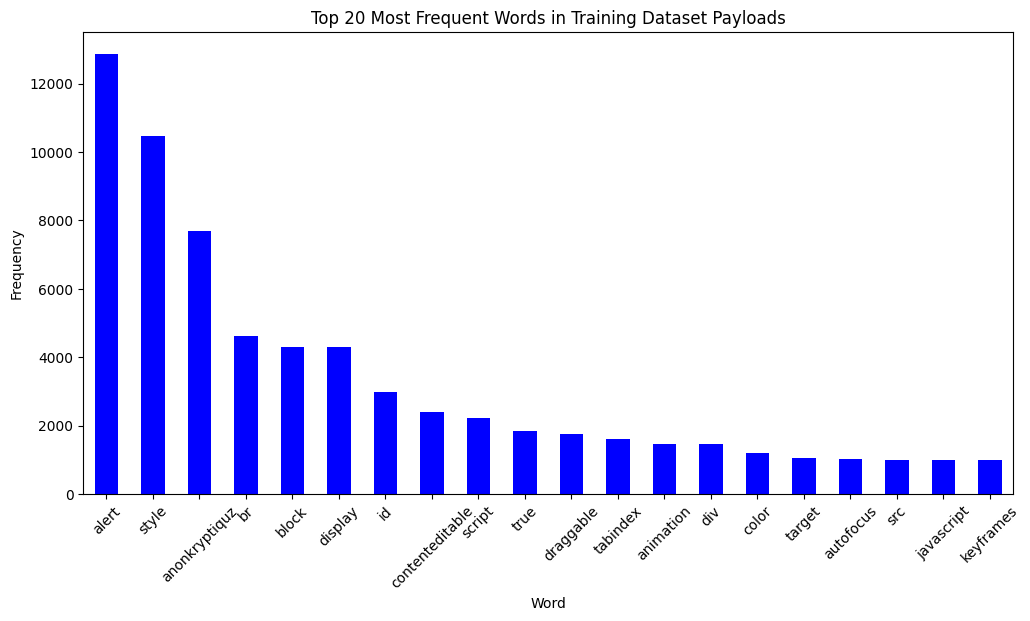

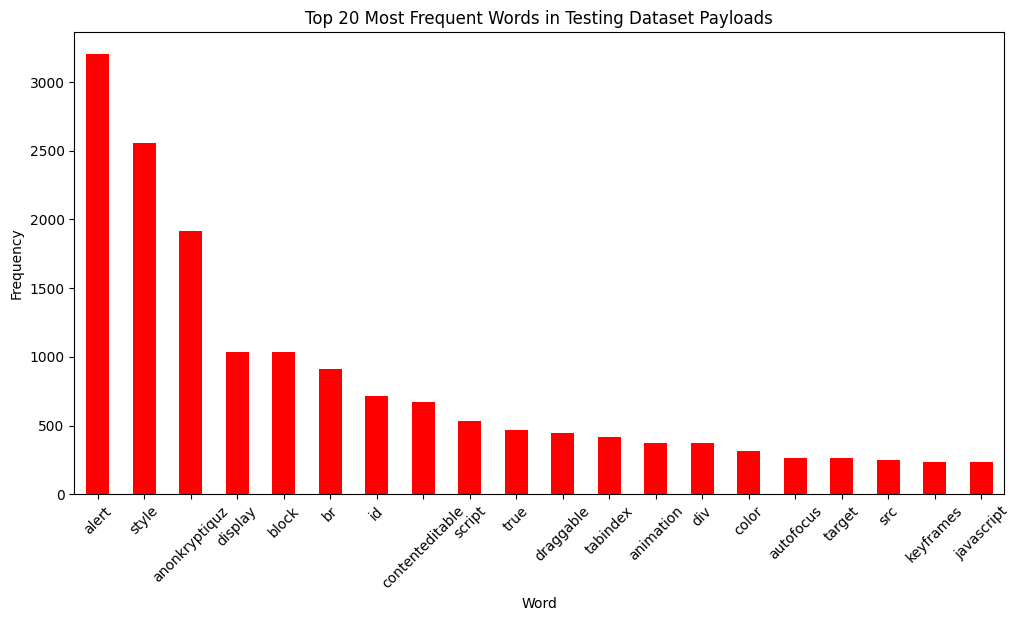

In [19]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)

train_word_counts = vectorizer.fit_transform(train_payloads_df['payload'])
test_word_counts = vectorizer.transform(test_payloads_df['payload'])

train_word_freq_df = pd.DataFrame(train_word_counts.toarray(), columns=vectorizer.get_feature_names_out())
test_word_freq_df = pd.DataFrame(test_word_counts.toarray(), columns=vectorizer.get_feature_names_out())

train_word_freq = train_word_freq_df.sum().sort_values(ascending=False)
test_word_freq = test_word_freq_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
train_word_freq.head(20).plot(kind='bar', color='blue')
plt.title('Top 20 Most Frequent Words in Training Dataset Payloads')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
test_word_freq.head(20).plot(kind='bar', color='red')
plt.title('Top 20 Most Frequent Words in Testing Dataset Payloads')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Pre-processing**

In [20]:
max_sequence_length = 3098
vocab_size = vocab_size_SET = 175
new_max_sequence_length = 100

learning_rate_SET = 0.001
epochs_SET = 10
patience_SET = 5
Dropout_SET = 0.2
batch_size_SET = 64
seq_length_SET = 70
GRU_SET = 64
output_dim_SET = 64
train_inputs_SET = 200000

max_length_SET = 70
max_repeats_SET = 3
tempurature_SET = 0.3

model_name = "best_model.keras"

In [22]:
all_payloads = train_payloads + test_payloads

with open("payloads.txt", "w", encoding="utf-8") as f:
    for payload in all_payloads:
        f.write(payload + "\n")

spm.SentencePieceTrainer.train(
    input="payloads.txt",
    model_prefix="xss_tokenizer",
    vocab_size=vocab_size_SET,
    model_type="bpe"
)

sp = spm.SentencePieceProcessor()
sp.load("xss_tokenizer.model")

train_sequences = [sp.encode_as_ids(payload) for payload in train_payloads]
test_sequences = [sp.encode_as_ids(payload) for payload in test_payloads]

print("Total unique tokens in the dataset:", sp.get_piece_size())
print("Example payload:", train_payloads[0])
print("Tokenized sequence:", train_sequences[0])

Total unique tokens in the dataset: 175
Example payload: {{constructor.constructor(valueOf.name.constructor.fromCharCode(97,108,101,114,116,40,49,41,10))()}}

Tokenized sequence: [89, 126, 126, 67, 11, 85, 98, 100, 83, 86, 85, 131, 67, 11, 85, 98, 100, 83, 86, 85, 107, 73, 91, 74, 164, 113, 131, 87, 88, 39, 131, 67, 11, 85, 98, 100, 83, 86, 85, 131, 113, 64, 104, 133, 120, 88, 85, 133, 86, 52, 107, 146, 144, 148, 105, 119, 134, 148, 105, 119, 105, 148, 105, 105, 141, 148, 105, 105, 137, 148, 141, 119, 148, 141, 146, 148, 141, 105, 148, 105, 119, 106, 106, 107, 106, 125, 125]


In [23]:
max_train_length = max(len(seq) for seq in train_sequences)
max_test_length = max(len(seq) for seq in test_sequences)
max_length = max(max_train_length, max_test_length)

train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

print("Maximum length of payloads:", max_length)
print("Shape of training data after padding:", train_padded.shape)
print("Shape of testing data after padding:", test_padded.shape)
print("Example padded sequence:", train_padded[0])

Maximum length of payloads: 2418
Shape of training data after padding: (14437, 3098)
Shape of testing data after padding: (3609, 3098)
Example padded sequence: [ 89 126 126 ...   0   0   0]


In [24]:
train_data, val_data = train_test_split(train_padded, test_size=0.2, random_state=42)

print("Training Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)

Training Data Shape: (11549, 3098)
Validation Data Shape: (2888, 3098)


**Model building**

In [25]:
inputs = Input(shape=(max_sequence_length,))
x = Embedding(input_dim=vocab_size, output_dim=output_dim_SET)(inputs)

x = Bidirectional(GRU(GRU_SET, return_sequences=True))(x)
x = Dropout(Dropout_SET)(x)

x = Bidirectional(GRU(GRU_SET))(x)
x = Dropout(Dropout_SET)(x)

outputs = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

def f1_score(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')

    tp = K.sum(K.cast((y_true == y_pred) & (y_true > 0), 'float32'))
    fp = K.sum(K.cast((y_true != y_pred) & (y_pred > 0), 'float32'))
    fn = K.sum(K.cast((y_true != y_pred) & (y_true > 0), 'float32'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate_SET),
    metrics=['accuracy', f1_score]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3098)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 3098, 64)            │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3098, 128)           │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3098, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 175)                 │          22,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,191 (617.93 KB)

 Trainable params: 158,191 (617.93 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
train_data_truncated = train_data[:, :new_max_sequence_length]
val_data_truncated = val_data[:, :new_max_sequence_length]

print("Truncated Training Data Shape:", train_data_truncated.shape)
print("Truncated Validation Data Shape:", val_data_truncated.shape)

Truncated Training Data Shape: (11549, 100)
Truncated Validation Data Shape: (2888, 100)


In [27]:
def create_input_output_pairs(data, seq_length):
    inputs = []
    targets = []
    for payload in data:
        for i in range(1, len(payload)):
            input_seq = payload[:i]
            inputs.append(input_seq)
            targets.append(payload[i])

    inputs_padded = pad_sequences(inputs, maxlen=seq_length, padding='post')
    return np.array(inputs_padded), np.array(targets)

seq_length = seq_length_SET

train_inputs, train_targets = create_input_output_pairs(train_data_truncated, seq_length)
val_inputs, val_targets = create_input_output_pairs(val_data_truncated, seq_length)

print("Training Inputs Shape:", train_inputs.shape)
print("Training Targets Shape:", train_targets.shape)
print("Validation Inputs Shape:", val_inputs.shape)
print("Validation Targets Shape:", val_targets.shape)

Training Inputs Shape: (1143351, 70)
Training Targets Shape: (1143351,)
Validation Inputs Shape: (285912, 70)
Validation Targets Shape: (285912,)


**Model Training**

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1314s 416ms/step - accuracy: 0.6301 - f1_score: 0.0927 - loss: 1.8939 - val_accuracy: 0.7557 - val_f1_score: 0.3835 - val_loss: 1.0724
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1341s 415ms/step - accuracy: 0.7750 - f1_score: 0.4488 - loss: 0.9807 - val_accuracy: 0.8171 - val_f1_score: 0.5078 - val_loss: 0.8089
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1340s 415ms/step - accuracy: 0.8243 - f1_score: 0.5718 - loss: 0.7558 - val_accuracy: 0.8443 - val_f1_score: 0.5753 - val_loss: 0.6920
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1343s 415ms/step - accuracy: 0.8486 - f1_score: 0.6304 - loss: 0.6403 - val_accuracy: 0.8567 - val_f1_score: 0.6058 - val_loss: 0.6273
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1276s 408ms/step - accuracy: 0.8644 - f1_score: 0.6679 - loss: 0.5685 - val_accuracy: 0.8652 - val_f1_score: 0.6259 - val_loss: 0.5888
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1306s 418ms/step - accuracy: 0.8735 - f1_score: 0.6891 - loss: 0.5254 - v

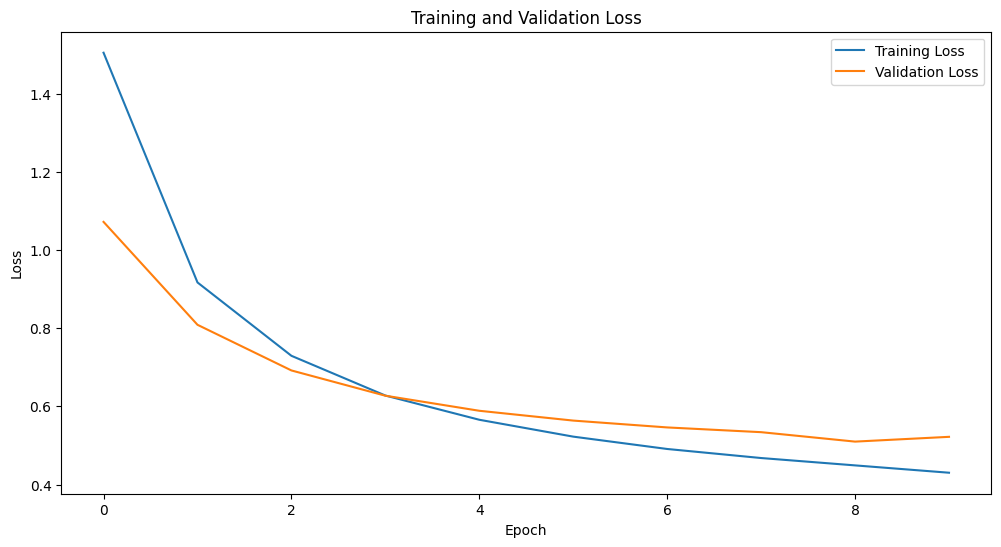

In [28]:
def f1_score(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, dtype='int64')

    tp = K.sum(K.cast(K.equal(y_true, y_pred) & K.greater(y_true, 0), 'float32'))
    fp = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.greater(y_pred, 0), 'float32'))
    fn = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.greater(y_true, 0), 'float32'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

train_inputs_sample = train_inputs[:train_inputs_SET]
train_targets_sample = train_targets[:train_inputs_SET]

seq_length = seq_length_SET
train_inputs_sample = pad_sequences(train_inputs_sample, maxlen=seq_length, padding='post')
val_inputs = pad_sequences(val_inputs, maxlen=seq_length, padding='post')

inputs = Input(shape=(seq_length,))
x = Embedding(input_dim=vocab_size, output_dim=output_dim_SET)(inputs)

x = Bidirectional(GRU(GRU_SET, return_sequences=True))(x)
x = Dropout(Dropout_SET)(x)

x = Attention()([x, x])

x = Bidirectional(GRU(GRU_SET))(x)
x = Dropout(Dropout_SET)(x)

outputs = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate_SET),
    metrics=['accuracy', f1_score]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience_SET,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

history = model.fit(
    train_inputs_sample,
    train_targets_sample,
    validation_data=(val_inputs, val_targets),
    batch_size=batch_size_SET,
    epochs=epochs_SET,
    callbacks=[early_stopping, checkpoint]
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Model Evaluation**

In [29]:
results = model.evaluate(val_inputs, val_targets, batch_size=batch_size_SET)
val_loss, val_accuracy, val_f1_score = results

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")

4468/4468 ━━━━━━━━━━━━━━━━━━━━ 382s 85ms/step - accuracy: 0.8846 - f1_score: 0.6752 - loss: 0.5077
Validation Loss: 0.5098
Validation Accuracy: 0.8849
Validation F1 Score: 0.6763


**Model Inference**

In [76]:
def generate_payload(model, sp, seed_text, max_length=max_length_SET, temperature=tempurature_SET, max_repeats=max_repeats_SET):
    generated_payload = seed_text
    last_chars = []

    for _ in range(max_length - len(seed_text)):
        tokenized_payload = sp.encode_as_ids(generated_payload)
        padded_payload = pad_sequences([tokenized_payload], maxlen=max_length, padding='post')
        predictions = model.predict(padded_payload, verbose=0)[0]

        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        predicted_token = np.random.choice(len(predictions), p=predictions)

        predicted_char = sp.id_to_piece(predicted_token) if predicted_token != 0 else ''

        print(f"Predicted Token: {predicted_token}, Predicted Character: '{predicted_char}'")

        if predicted_token == 0 or predicted_token == 1:
            print("Skipping invalid token.")
            continue

        last_chars.append(predicted_char)
        if len(last_chars) > max_repeats and len(set(last_chars[-max_repeats:])) == 1:
            print("Skipping repeated character.")
            continue

        generated_payload += predicted_char

    return generated_payload

seed_text = "<script>alert(\"AnonKryptiQuz\")"
temperatures = [0.1, 0.3, 0.5, 1.0]
payloads = []

print("XSS Payload Generator by AnonKryptiQuz\n")
for temp in temperatures:
    generated_payload = generate_payload(
        model, sp, seed_text, max_length=max_length_SET, temperature=temp
    )
    payloads.append((temp, generated_payload))
    print(f"Generated Payload (Temperature: {temp}):", generated_payload, '\n')

XSS Payload Generator by AnonKryptiQuz

Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicted Token: 0, Predicted Character: ''
Skipping invalid token.
Predicte

In [77]:
print("\nProgram Made by AnonKryptiQuz\n")
print(f"Seed Text: {seed_text}\n")
for idx, (temp, payload) in enumerate(payloads, start=1):
    print(f"Payload {idx} (Temperature: {temp}): {payload}")


Program Made by AnonKryptiQuz

Seed Text: <script>alert("AnonKryptiQuz")

Payload 1 (Temperature: 0.1): <script>alert("AnonKryptiQuz")
Payload 2 (Temperature: 0.3): <script>alert("AnonKryptiQuz");</script>
Payload 3 (Temperature: 0.5): <script>alert("AnonKryptiQuz")</script>
Payload 4 (Temperature: 1.0): <script>alert("AnonKryptiQuz")</script>
